# Model Compression 

We will try Pruning and Quantization on the trained Model

In [1]:
import torch

from transformers import (AutoModelForSequenceClassification, AutoTokenizer,TextClassificationPipeline)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


We will change the device to __CPU__ for benchmarking

In [2]:
from pathlib import Path
from time import perf_counter
import numpy as np
from tqdm import tqdm

from datasets import load_metric
accuracy_score = load_metric('accuracy')

class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        preds, labels = [], []
        for example in tqdm(self.dataset,desc='Computing Accuracy'):
            pred = self.pipeline(example["text"])[0]["label"].split('_')[1]
            label = example["labels"]
            # preds.append(intents.str2int(pred))
            preds.append(pred)
            labels.append(label)
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_pipeline(self,query="What is the pin number for my account?"):
        latencies = []
        # Warmup
        for _ in range(10):
            _ = self.pipeline(query)
        # Timed run
        for _ in tqdm(range(100),desc='Latency Check'):
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {self.optim_type: self.compute_size()}
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [3]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    plt.figure(figsize=(10,5))
    for idx in df.index:
        df_opt = df.loc[idx]
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    
    plt.ylim(80,90)
    plt.xlim(5, 53)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()


In [4]:
from datasets import load_dataset
clinc = load_dataset("clinc_oos","plus")
clinc.rename_column_('intent','labels')
clinc

Reusing dataset clinc_oos (C:\Users\Subha\.cache\huggingface\datasets\clinc_oos\plus\1.0.0\abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)
C:\Users\Subha\.conda\envs\nlp\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: rename_column_ is deprecated and will be removed in the next major version of datasets. Use DatasetDict.rename_column instead.
  This is separate from the ipykernel package so we can avoid doing imports until


DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5500
    })
})

### _Default Model:_ DistilRoberta-Base

In [5]:
MODEL_DIR = './models/squeezebert-uncased'
MODEL_NAME = 'squeezebert-uncased'

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

model.to('cpu')
 
pipe = TextClassificationPipeline(model = model,tokenizer= tokenizer)


In [7]:
pb = PerformanceBenchmark(pipe, clinc["test"],optim_type=MODEL_NAME)
perf_metrics = pb.run_benchmark()


Model size (MB) - 195.44


Computing Accuracy:   0%|          | 2/5500 [00:00<05:46, 15.87it/s]

Average latency (ms) - 58.89 +\- 9.64


Computing Accuracy: 100%|██████████| 5500/5500 [04:41<00:00, 19.56it/s]


Accuracy on test set - 0.798


In [9]:
perf_metrics

{'squeezebert-uncased': {'size_mb': 195.43865871429443,
  'time_avg_ms': 58.88742800000216,
  'time_std_ms': 9.642020811946502,
  'accuracy': 0.7981818181818182}}

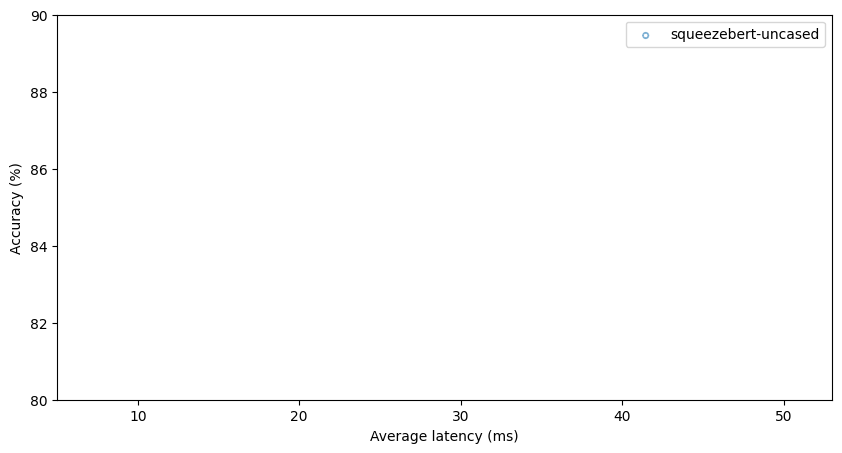

In [8]:
plot_metrics(perf_metrics,MODEL_NAME)

# Pruning

## Unstructured Pruning

In [10]:
from torch.nn.utils import prune 
pruner = prune.L1Unstructured(amount=0.1)
pr_model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to('cpu')

state_dict = pr_model.state_dict()

for key in state_dict.keys(): 
    if "weight" in key: 
        state_dict[key] = pruner.prune(state_dict[key])

pr_model.load_state_dict(state_dict)

<All keys matched successfully>

Model size (MB) - 195.44


Computing Accuracy:   0%|          | 2/5500 [00:00<04:37, 19.80it/s]

Average latency (ms) - 52.09 +\- 8.12


Computing Accuracy: 100%|██████████| 5500/5500 [04:11<00:00, 21.88it/s]


Accuracy on test set - 0.680


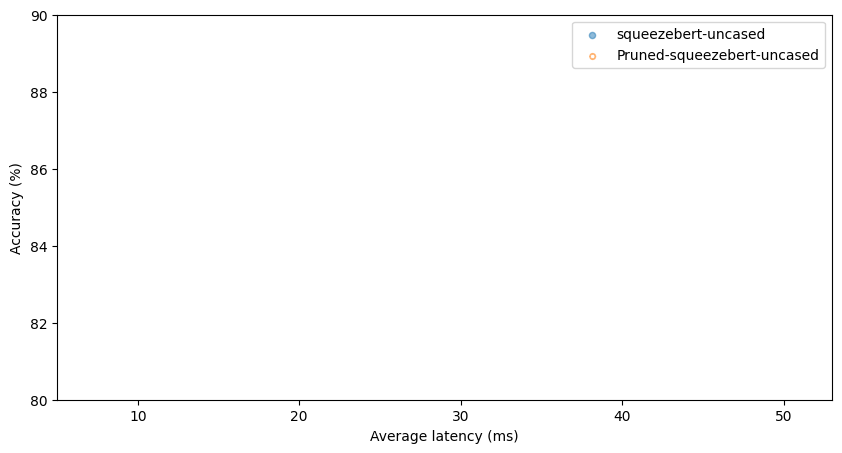

In [11]:
pruned_pipe = TextClassificationPipeline(model = pr_model,tokenizer= tokenizer)

pb = PerformanceBenchmark(pruned_pipe, clinc["test"],optim_type=f'Pruned-{MODEL_NAME}')
perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics,f'Pruned-{MODEL_NAME}')

# Quantization


## Quanitzation

In [12]:
import torch 


squeezebert_quan = torch.quantization.quantize_dynamic(
    model=model,
    qconfig_spec = {torch.nn.Linear: torch.quantization.default_dynamic_qconfig}, dtype=torch.qint8)

In [13]:
squeezebert_quan.device

device(type='cpu')

Model size (MB) - 193.42


Computing Accuracy:   0%|          | 2/5500 [00:00<04:48, 19.05it/s]

Average latency (ms) - 57.06 +\- 8.44


Computing Accuracy: 100%|██████████| 5500/5500 [04:25<00:00, 20.75it/s]


Accuracy on test set - 0.798


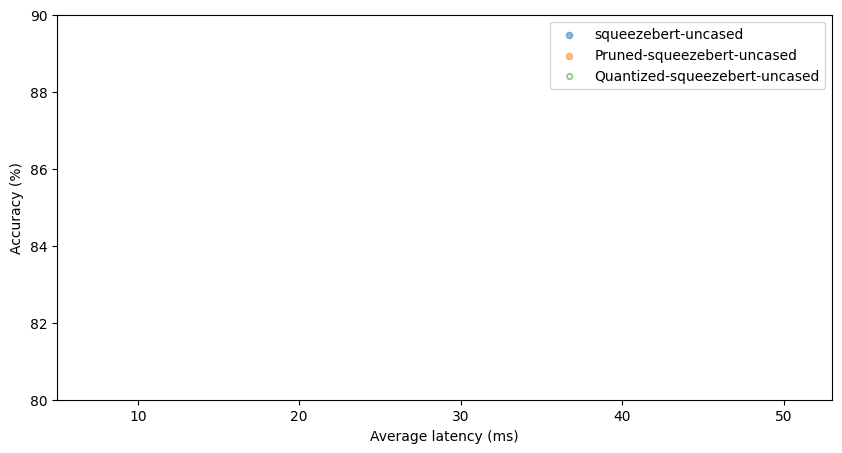

In [14]:
quantized_pipe = TextClassificationPipeline(model = squeezebert_quan,tokenizer= tokenizer)

pb = PerformanceBenchmark(quantized_pipe, clinc["test"],optim_type=f'Quantized-{MODEL_NAME}')
perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics,f'Quantized-{MODEL_NAME}')


## Pruning + Quantization

In [15]:

# squeezebert_quan_pr = torch.quantization.quantize_dynamic(
#     model=pr_model,
#     qconfig_spec = {torch.nn.Linear: torch.quantization.default_dynamic_qconfig}, dtype=torch.qint8)

In [16]:
# pruned_quantized_pipe = TextClassificationPipeline(model = squeezebert_quan_pr,tokenizer= tokenizer)

# pb = PerformanceBenchmark(pruned_quantized_pipe, clinc["test"],optim_type=f'Pruned-Quantized-{MODEL_NAME}')
# perf_metrics.update(pb.run_benchmark())
# plot_metrics(perf_metrics,f'Pruned-Quantized-{MODEL_NAME}')

# ONNX

In [18]:
from transformers.convert_graph_to_onnx import convert

onnx_model_path = Path("models/squeezebert-onnx/squeezebert.onnx")
convert(framework="pt", model=model, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="sentiment-analysis")

ONNX opset version set to: 12
Loading pipeline (model: SqueezeBertForSequenceClassification(
  (transformer): SqueezeBertModel(
    (embeddings): SqueezeBertEmbeddings(
      (word_embeddings): Embedding(30528, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): SqueezeBertEncoder(
      (layers): ModuleList(
        (0): SqueezeBertModule(
          (attention): SqueezeBertSelfAttention(
            (query): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
            (key): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
            (value): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
            (dropout): Dropout(p=0.1, inplace=False)
            (softmax): Softmax(dim=-1)
            (matmul_qk): MatMulWrapper()
            (matmul_qkv): MatMulW

C:\Users\Subha\.conda\envs\nlp\lib\site-packages\transformers\models\squeezebert\modeling_squeezebert.py:79: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  position_ids = self.position_ids[:, :seq_length]


In [19]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [20]:
onnx_model = create_model_for_provider(onnx_model_path)

In [21]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": pred_idx, "score": probs[pred_idx]}]


query = 'I want to book a cab to the airport'
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 63, 'score': 0.07836581}]

In [22]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def compute_accuracy(self):
        preds, labels = [], []
        for example in tqdm(self.dataset,desc='Computing Accuracy'):
            pred = self.pipeline(example["text"])[0]["label"]
            label = example["labels"]
            # preds.append(intents.str2int(pred))
            preds.append(pred)
            labels.append(label)
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

In [23]:
optim_type = "ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=onnx_model_path)
perf_metrics.update(pb.run_benchmark())

Latency Check:   0%|          | 0/100 [00:00<?, ?it/s]

Model size (MB) - 195.43


Computing Accuracy:   0%|          | 6/5500 [00:00<01:32, 59.41it/s]

Average latency (ms) - 16.33 +\- 2.21


Computing Accuracy: 100%|██████████| 5500/5500 [01:28<00:00, 61.81it/s]

Accuracy on test set - 0.798


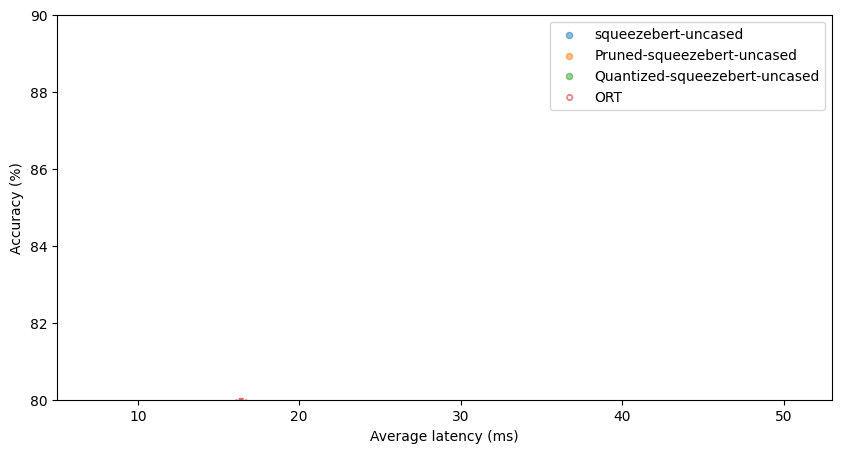

In [24]:
plot_metrics(perf_metrics, optim_type)

## ONNX + Quantization

In [32]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_output = "models/squeezebert-onnx/squeezebert.quant.onnx"
quantize_dynamic(onnx_model_path, model_output, weight_type=QuantType.QUInt8)

Latency Check:   0%|          | 0/100 [00:00<?, ?it/s]

Model size (MB) - 49.41


Computing Accuracy:   0%|          | 6/5500 [00:00<01:48, 50.86it/s]

Average latency (ms) - 18.23 +\- 1.15


Computing Accuracy: 100%|██████████| 5500/5500 [01:39<00:00, 55.37it/s]


Accuracy on test set - 0.796


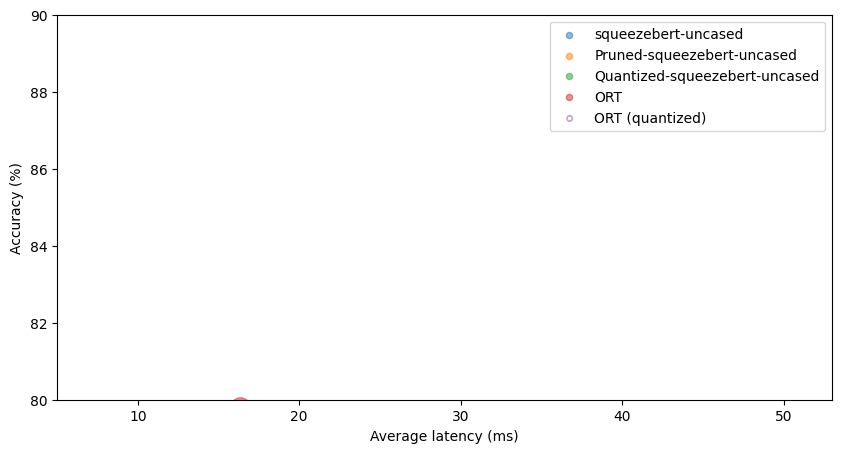

In [33]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics, optim_type)

## ONNX + Quantization + No Padding

In [34]:
class OnnxPipelineNoPadding(OnnxPipeline):
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt",padding=False)
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": pred_idx, "score": probs[pred_idx]}]


query = 'I want to book a cab to the airport'
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 63, 'score': 0.07836581}]

Model size (MB) - 49.41


Computing Accuracy:   0%|          | 6/5500 [00:00<01:41, 54.03it/s]

Average latency (ms) - 18.14 +\- 1.55


Computing Accuracy: 100%|██████████| 5500/5500 [01:36<00:00, 57.12it/s]


Accuracy on test set - 0.796


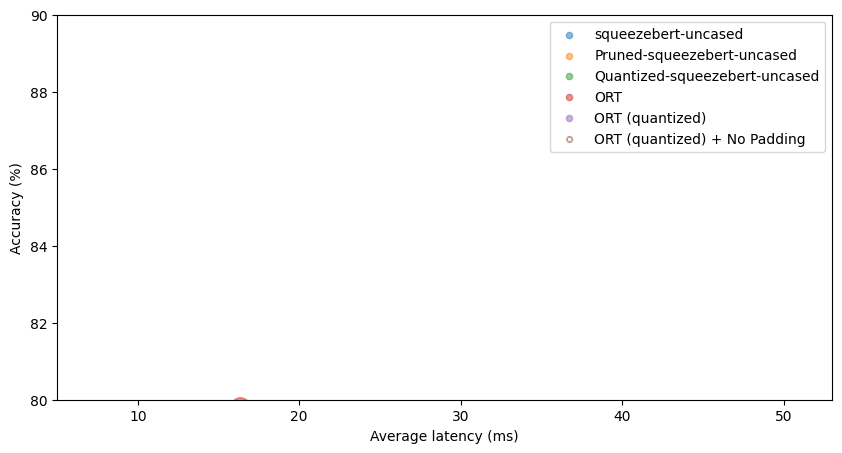

In [35]:
pipe = OnnxPipelineNoPadding(onnx_quantized_model, tokenizer)
optim_type = "ORT (quantized) + No Padding"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics, optim_type)